# notebook概要：
这个notebook主要研究平稳化的问题：
- 第一部分将原序列对数变化后进行ARIMA拟合；
- 第二部分


## 第一部分：将原序列对数变化后进行ARIMA拟合

In [2]:
#!/usr/bin/env python
# coding=utf-8
# -------- import basic package --------
%pylab inline
import pdb
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import warnings
import random
from datetime import datetime
import matplotlib.pylab as plt

from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

PATH = 'F:/codeGit/dataset/Purchase&Redemption/'
FILE_BANK = 'mfd_bank_shibor.csv'
FILE_SHARE = 'mfd_day_share_interest.csv'
FILE_USER_BALANCE = 'user_balance_table.csv'
FILE_USER_PROFILE = 'user_profile_table.csv'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
df_userBalan = pd.read_csv(PATH + FILE_USER_BALANCE)
df_userBalan = df_userBalan[["user_id", "report_date", "total_purchase_amt", "consume_amt", "transfer_amt"]]
df_userBalan['time'] = pd.to_datetime(df_userBalan['report_date'], format = '%Y%m%d')
df_userBalan = df_userBalan.drop(['report_date'], axis = 1)
df_userBalan['year_month'] = df_userBalan['time'].dt.strftime('%Y-%m')
df_userBalan['day'] = df_userBalan['time'].dt.day
df_userBalan.set_index(['user_id', 'year_month'])
print df_userBalan[:5]

temp_gp = df_userBalan.groupby(['user_id', 'year_month'])
df_mcp = DataFrame(dict(
        max_consume = temp_gp.consume_amt.max(),
        max_purchase = temp_gp.total_purchase_amt.max()
    )).reset_index()
df_mcp = df_mcp[pd.notnull(df_mcp['max_consume'])]

temp_gp = df_userBalan.groupby(['time'])
df_rp_date = DataFrame(dict(
    total_reedom = temp_gp.consume_amt.sum() + temp_gp.transfer_amt.sum(),
    total_purchase = temp_gp.total_purchase_amt.sum(),
    )).reset_index()
df_rp_date.index = df_rp_date['time']    

   user_id  total_purchase_amt  consume_amt  transfer_amt       time  \
0        1                   2            0             0 2014-08-05   
1        1                   2            0             0 2014-08-08   
2        1                   2            0             0 2014-08-11   
3        1                   2            0             0 2014-08-14   
4        1                   2            0             0 2014-08-17   

  year_month  day  
0    2014-08    5  
1    2014-08    8  
2    2014-08   11  
3    2014-08   14  
4    2014-08   17  


### 测试对数变换的影响

In [108]:
df_test = df_rp_date[df_rp_date.time >= '2014-02-01']

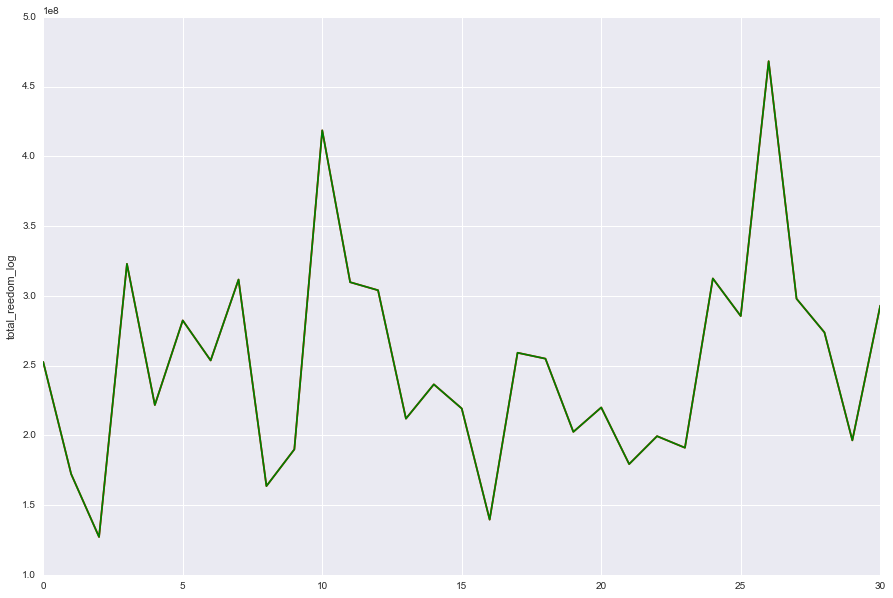

In [34]:
plt.figure(figsize=(15,10))
df_test['total_reedom_log'] = df_test['total_reedom'].apply(lambda x: math.log1p(x))
df_test['total_reedom_unlog'] = df_test['total_reedom_log'].apply(lambda x: math.exp(x))

plt.plot(range(len(df_test)), df_test['total_reedom'], color = 'r')
plt.plot(range(len(df_test)), df_test['total_reedom_unlog'], color = 'g')
plt.ylabel('total_reedom_log')

如上证明对数变换后由变换回来的并没有影响原序列

### 以21014年8月作为分界分为训练集与测试集：

In [ ]:
df_test = df_rp_date[df_rp_date.time >= '2014-02-01']
df_train = df_rp_date[df_rp_date.time < '2014-02-01']

### 对训练集进行对数变换后做拟合：

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: total_reedom_log                    Method: MLE                                       
Start Date: 2013-07-05 00:00:00                         Log Likelihood: -152.9832                         
End Date: 2014-01-31 00:00:00                           AIC: 325.9663                                     
Number of observations: 211                             BIC: 359.4849                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.3035     0.1712     1.7726   0.0763   (-0.0321 | 0.6392)       
AR(1)                                

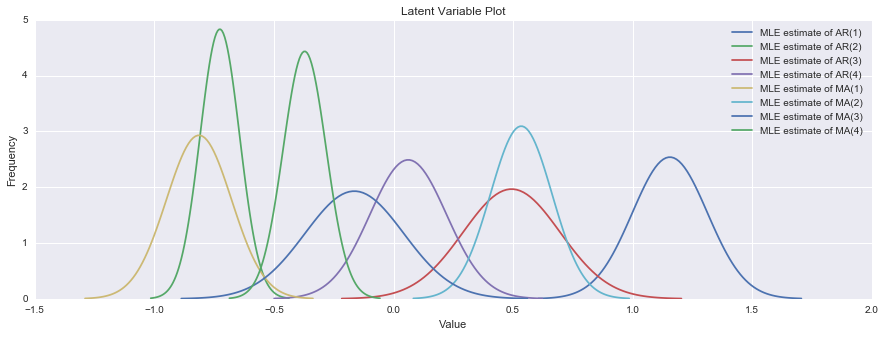

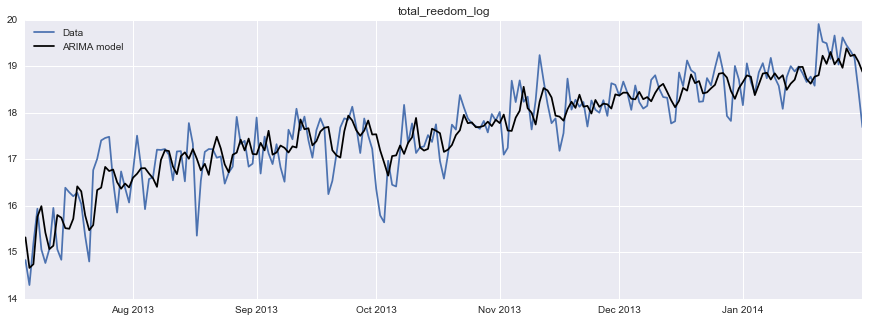

In [139]:
import pyflux as pf

df_train['total_reedom_log'] = df_train['total_reedom'].apply(lambda x: math.log1p(x))
model = pf.ARIMA(data=df_train,ar=4,ma=4,integ=0,target='total_reedom_log')
x = model.fit("MLE")
    # 使用MLE准则去拟合模型
x.summary()
model.plot_z(indices=range(1,9))
model.plot_fit(figsize=(15,5))

## 还原的误差比较

如上观察，对数变换对序列的平稳化有些效果。但是拟合效果不好说明对数变换还没有将时间序列中的非平稳因素去除干净。  
而且对数变换后的处理得不好，逆变换后的效果将被放大。
### 测试下实际的拟合效果：

#### 对数拟合效果

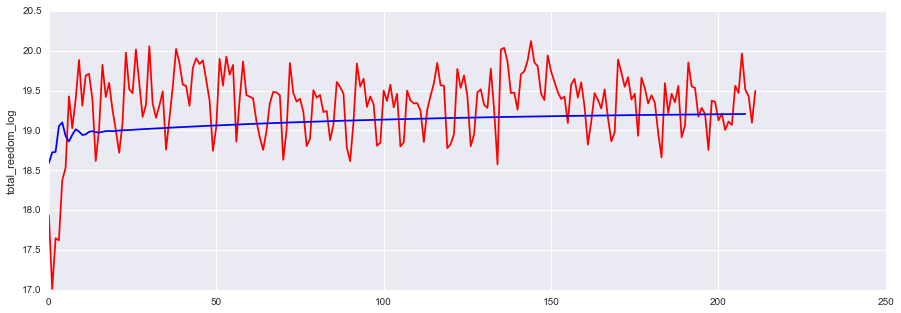

In [140]:
plt.figure(figsize=(15,5))
pred_log_april = model.predict(h = len(df_test)-3)
    
df_test['total_reedom_log'] = df_test['total_reedom'].apply(lambda x: math.log1p(x))    
plt.plot(range(len(df_test)), df_test['total_reedom_log'], color = 'r')
plt.plot(range(len(df_test)-3) , pred_log_april, color = 'b')
plt.ylabel('total_reedom_log')

#### 逆变换后

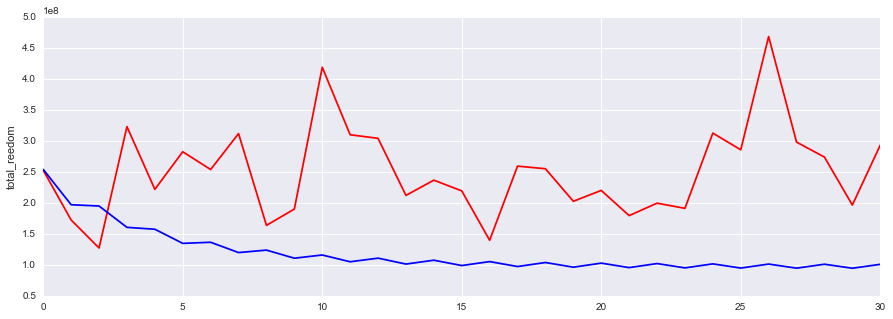

In [100]:
plt.figure(figsize=(15,5))

pred_log_april = model.predict(h = 31)
pre = []
for elem in pred_log_april.values:
    pre.append(math.exp(elem[0]) - 1)

df_pred = Series(pre, index = df_test['time'])
plt.plot(range(len(df_test)), df_test['total_reedom'], color = 'r')
plt.plot(range(len(df_test)), df_pred, color = 'b')
plt.ylabel('total_reedom')

第一部分总结:(可以看出效果差得不能直视。。。。。)
    1、主要原因是对数变换后的序列的幅值差距被大幅降低，这时即对应原序列的趋势成分被大幅削减。  
    2、而对对数变换后的序列进行ARIMA拟合时，默认把对数变换都的序列当做平稳序列进行拟合，故趋势部分没有被拟合或被削减  
    3、而预测仅仅预测的是趋势的部分，故逆变换后仅留下平稳的变化效果  

In [ ]:
plt.figure(figsize=(15,10))
df_train['reedom_fit_log'] = Series(model.data, index = df_train['time'])
df_train['reedom_fit'] = df_train['reedom_fit_log'].apply(lambda x: math.exp(x) - 1)

plt.plot(range(len(df_train)), df_train['total_reedom'], color = 'r')
plt.plot(range(len(df_train)), df_train['reedom_fit'], color = 'b')
plt.ylabel('reedom')

#print df_train['total_reedom_log'][:5], df_train['reedom_fit_log'][:5]
#print model.data

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(df_test)), df_test['total_reedom'], color = 'r')
plt.plot(range(len(df_test)), pred_reedom['total_reedom'], color = 'b')
plt.ylabel('total_reedom_log')
plt.title('Yearly total_reedom_log')

In [ ]:
def gen_submiss(reedom, purchase):

In [17]:
help(model)
    

Help on ARIMA in module pyflux.arma.arma object:

class ARIMA(pyflux.tsm.TSM)
 |  Inherits time series methods from the TSM parent class.
 |  
 |  **** AUTOREGRESSIVE INTEGRATED MOVING AVERAGE (ARIMA) MODELS ****
 |  
 |  Parameters
 |  ----------
 |  data : pd.DataFrame or np.ndarray
 |      Field to specify the univariate time series data that will be used.
 |  
 |  ar : int
 |      Field to specify how many AR lags the model will have.
 |  
 |  ma : int
 |      Field to specify how many MA lags the model will have.
 |  
 |  integ : int (default : 0)
 |      Specifies how many times to difference the time series.
 |  
 |  target : str (if data is a pd.DataFrame) or int (if data is a np.ndarray)
 |      Specifies which column name or array index to use. By default, first
 |      column/array index will be selected as the dependent variable.
 |  
 |  family : family object
 |      E.g pf.Normal(), pf.t(), pf.Laplace()...
 |  
 |  Method resolution order:
 |      ARIMA
 |      pyflux.ts

In [ ]:
from sklearn.kernel_ridge import KernelRidge

model = Ridge(alpha = 1.0, normalize = False)
# model = KernelRidge(alpha = 2.0)
# model = model.fit(np.mat([1, 2]).T, np.array([1, 2]).T)
X = np.mat(range(len(df_rp_date))).T
quadratic_featurizer = PolynomialFeatures(degree=5)
X_train_quadratic = quadratic_featurizer.fit_transform(X)

model = model.fit(X_train_quadratic, df_rp_date['total_reedom_log'].values)
preds_reed_log = model.predict(X_train_quadratic)

plt.figure(figsize=(15,5))
plt.plot(range(len(df_rp_date)), df_rp_date['total_reedom_log'])
plt.plot(range(len(df_rp_date)), Series(preds_reed_log))
plt.ylabel('total_reedom_log')
plt.title('Yearly total_reedom_log')

In [ ]:
signal_log = df_rp_date['total_reedom_log'].values - preds_reed_log
plt.figure(figsize=(15,5))
plt.plot(range(len(df_rp_date)), signal_log)
plt.ylabel('total_reedom')
plt.title('Yearly total_reedom_log')

In [ ]:
model = pf.ARIMA(data=signal_log,ar=4,ma=4,integ=0)
x = model.fit("MLE")
    # 使用MLE准则去拟合模型
x.summary()
model.plot_fit(figsize=(15,5))

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(df_rp_date)), df_rp_date['total_reedom_log'], color = 'r')

temp = df_rp_date['total_reedom_log'] - Series(preds_reed_log + signal_log)
print temp
plt.plot(range(len(df_rp_date)), Series(preds_reed_log + signal_log), color = 'b')
plt.ylabel('total_reedom_log')
plt.title('Yearly total_reedom_log')